In [14]:
from prometheus_pandas import query
import prometheus_pandas.ipython.magic
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

#Time Interval


In [15]:
global start, end
start = '2022-12-29T15:40:00Z'
end = '2022-12-29T15:42:00Z'

#Latency

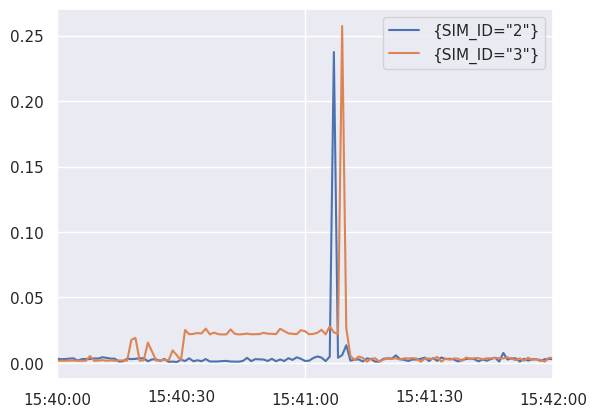

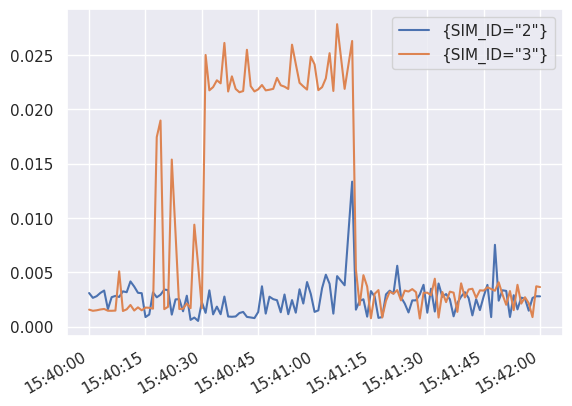

In [16]:
p = query.Prometheus('http://r4-infrastructure-prometheus-server.ricplt.svc.cluster.local:80')
df = p.query_range('sum by (SIM_ID) (rc_control_loop_latency_seconds)',start, end, '1s')
df.to_csv(start+'-out-latency.csv')
df.plot(kind='line')
index = df[ (df['{SIM_ID="2"}'] > 0.1) | (df['{SIM_ID="3"}'] > 0.1)].index
df.drop(index , inplace=True)
df.plot(kind='line')
plt.savefig(start+'-latency.pdf', bbox_inches='tight')
plt.savefig(start+'-latency.png', dpi=300, bbox_inches='tight')


#Memory Nodes

In [17]:
df = p.query_range('sum by (kubernetes_node) (node_memory_MemTotal_bytes - node_memory_MemAvailable_bytes)',start, end, '1s')
df.to_csv(start+'-out-node-mem.csv')

#CPU Nodes

In [18]:
df = p.query_range('sum by (kubernetes_node) (rate(node_cpu_seconds_total{mode!="idle"}[1m]))',start, end, '1s')
df.to_csv(start+'-out-node-cpu.csv')


#RIC Pods CPU

In [19]:
df = p.query_range('sum by (pod) (rate(container_cpu_usage_seconds_total{namespace=~"ric.*"}[1m]))',start, end, '1s')
df.to_csv(start+'-out-pod-cpu.csv')


/home/vmadmin/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


#RIC Pods Memory

In [20]:
df = p.query_range('sum by (pod) (container_memory_working_set_bytes{namespace=~"ric.*"})',start, end, '1s')
df.to_csv(start+'-out-pod-mem.csv')

/home/vmadmin/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


#Get Logs

In [21]:
from kubernetes import client, config
import os

config.load_kube_config()
v1 = client.CoreV1Api()
ret = v1.list_pod_for_all_namespaces(watch=False)
for i in ret.items:
    if  ('optimizer' in i.metadata.name):
        os.system('kubectl logs --timestamps=true '+i.metadata.name+' -n ricinfra > '+start+'-optimizer.logs')
    if  ('deployer' in i.metadata.name):
        os.system('kubectl logs --timestamps=true '+i.metadata.name+' -n ricinfra> '+start+'-deployer.logs')
            
